# Text-to-image generation using PhotoMaker and OpenVINO

PhotoMaker is an efficient personalized text-to-image generation method, which mainly encodes an arbitrary number of input ID images into a stack ID embedding for preserving ID information. Such an embedding, serving as a unified ID representation, can not only encapsulate the characteristics of the same input ID comprehensively, but also accommodate the characteristics of different IDs for subsequent integration. This paves the way for more intriguing and practically valuable applications. Users can input one or a few face photos, along with a text prompt, to receive a customized photo or painting (no training required!). Additionally, this model can be adapted to any base model based on `SDXL` or used in conjunction with other `LoRA` modules.More details about PhotoMaker can be found in the [technical report](https://arxiv.org/pdf/2312.04461.pdf).


This notebook explores how to speed up PhotoMaker pipeline using OpenVINO.
 

#### Table of contents:

- [PhotoMaker pipeline introduction](#PhotoMaker-pipeline-introduction)
- [Prerequisites](#Prerequisites)
- [Load original pipeline and prepare models for conversion](#Load-original-pipeline-and-prepare-models-for-conversion)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
    - [ID Encoder](#ID-Encoder)
    - [Text Encoder](#Text-Encoder)
    - [U-Net](#U-Net)
    - [VAE Decoder](#VAE-Decoder)
- [Prepare Inference pipeline](#Prepare-Inference-pipeline)
    - [Select inference device for Stable Diffusion pipeline](#Select-inference-device-for-Stable-Diffusion-pipeline)
    - [Compile models and create their Wrappers for inference](#Compile-models-and-create-their-Wrappers-for-inference)
- [Running Text-to-Image Generation with OpenVINO](#Running-Text-to-Image-Generation-with-OpenVINO)
- [Interactive Demo](#Interactive-Demo)



## PhotoMaker pipeline introduction
[back to top ⬆️](#Table-of-contents:)


For the proposed PhotoMaker,
we first obtain the text embedding and image embeddings from `text encoder(s)` and `image(ID) encoder`, respectively. Then, we extract the
fused embedding by merging the corresponding class embedding (e.g., man and woman) and each image embedding. Next, we concatenate
all fused embeddings along the length dimension to form the stacked ID embedding. Finally, we feed the stacked ID embedding to all
cross-attention layers for adaptively merging the ID content in the `diffusion model`. Note that although we use images of the same ID with
the masked background during training, we can directly input images of different IDs without background distortion to create a new ID
during inference. 

<img width="675" alt="image" src="https://github.com/OpenVINO-dev-contest/llama2.openvino/assets/91237924/49bae3d1-7a94-45b8-9bc8-72c191aa0713">

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Clone PhotoMaker repository

In [1]:
from pathlib import Path

if not Path("PhotoMaker").exists():
    !git clone https://github.com/TencentARC/PhotoMaker.git

Cloning into 'PhotoMaker'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 236 (delta 114), reused 65 (delta 48), pack-reused 91
Receiving objects: 100% (236/236), 9.31 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (120/120), done.


Install required packages

In [2]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu\
transformers "torch>=2.1" "diffusers>=0.26" "gradio>=4.19" "openvino>=2024.0.0" torchvision "peft==0.6.2" "nncf>=2.9.0" "protobuf==3.20.3"

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


Prepare PyTorch models

In [3]:
adapter_id = "TencentARC/PhotoMaker"
base_model_id = "SG161222/RealVisXL_V3.0"

TEXT_ENCODER_OV_PATH = Path("model/text_encoder.xml")
TEXT_ENCODER_2_OV_PATH = Path("model/text_encoder_2.xml")
UNET_OV_PATH = Path("model/unet.xml")
ID_ENCODER_OV_PATH = Path("model/id_encoder.xml")
VAE_DECODER_OV_PATH = Path("model/vae_decoder.xml")

## Load original pipeline and prepare models for conversion

[back to top ⬆️](#Table-of-contents:)

For exporting each PyTorch model, we will download the `ID encoder` weight, `LoRa` weight from HuggingFace hub, then using the `PhotoMakerStableDiffusionXLPipeline` object from repository of PhotoMaker to generate the original PhotoMaker pipeline.

In [4]:
import torch
import numpy as np
import os
from PIL import Image
from pathlib import Path
from PhotoMaker.photomaker.model import PhotoMakerIDEncoder
from PhotoMaker.photomaker.pipeline import PhotoMakerStableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
import gc

trigger_word = "img"


def load_original_pytorch_pipeline_components(photomaker_path: str, base_model_id: str):
    # Load base model
    pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(base_model_id, use_safetensors=True).to("cpu")

    # Load PhotoMaker checkpoint
    pipe.load_photomaker_adapter(
        os.path.dirname(photomaker_path),
        subfolder="",
        weight_name=os.path.basename(photomaker_path),
        trigger_word=trigger_word,
    )
    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
    pipe.fuse_lora()
    gc.collect()
    return pipe

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


2024-04-23 21:09:49.291953: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 21:09:49.293771: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 21:09:49.328180: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 21:09:49.329067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 21:09:49.957456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
from huggingface_hub import hf_hub_download

photomaker_path = hf_hub_download(repo_id=adapter_id, filename="photomaker-v1.bin", repo_type="model")

pipe = load_original_pytorch_pipeline_components(photomaker_path, base_model_id)

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading PhotoMaker components [1] id_encoder from [/home/ea/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/d7ec3fc17290263135825194aeb3bc456da67cc5]...
Loading PhotoMaker components [2] lora_weights from [/home/ea/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/d7ec3fc17290263135825194aeb3bc456da67cc5]


## Convert models to OpenVINO Intermediate representation (IR) format

[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models conversion directly. We need to provide a model object, input data for model tracing to `ov.convert_model` function to obtain OpenVINO `ov.Model` object instance. Model can be saved on disk for next deployment using `ov.save_model` function.

The pipeline consists of five important parts:

* ID Encoder for generating image embeddings to condition by image annotation.
* Text Encoders for creating text embeddings to generate an image from a text prompt.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters.

More details about weights compression can be found in [OpenVINO documentation](https://docs.openvino.ai/2023.3/weight_compression.html).

In [6]:
import openvino as ov
import nncf


def flattenize_inputs(inputs):
    """
    Helper function for resolve nested input structure (e.g. lists or tuples of tensors)
    """
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64,
    torch.int32: ov.Type.i32,
    torch.int64: ov.Type.i64,
    torch.bool: ov.Type.boolean,
}


def prepare_input_info(input_dict):
    """
    Helper function for preparing input info (shapes and data types) for conversion based on example inputs
    """
    flatten_inputs = flattenize_inputs(input_dict.values())
    input_info = []
    for input_data in flatten_inputs:
        updated_shape = list(input_data.shape)
        if input_data.ndim == 5:
            updated_shape[1] = -1
        input_info.append((dtype_mapping[input_data.dtype], updated_shape))
    return input_info


def convert(model: torch.nn.Module, xml_path: str, example_input, input_info):
    """
    Helper function for converting PyTorch model to OpenVINO IR
    """
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            ov_model = ov.convert_model(model, example_input=example_input, input=input_info)
        ov_model = nncf.compress_weights(ov_model)
        ov.save_model(ov_model, xml_path)

        del ov_model
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### ID Encoder
[back to top ⬆️](#Table-of-contents:)

PhotoMaker merged image encoder and fuse module to create an ID Encoder. It will used to generate image embeddings to update text encoder's output(text embeddings) which will be the input for U-Net model.

In [7]:
id_encoder = pipe.id_encoder
id_encoder.eval()


def create_bool_tensor(*size):
    new_tensor = torch.zeros((size), dtype=torch.bool)
    return new_tensor


inputs = {
    "id_pixel_values": torch.randn((1, 1, 3, 224, 224)),
    "prompt_embeds": torch.randn((1, 77, 2048)),
    "class_tokens_mask": create_bool_tensor(1, 77),
}

input_info = prepare_input_info(inputs)

convert(id_encoder, ID_ENCODER_OV_PATH, inputs, input_info)

del id_encoder
gc.collect()

[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_utils.py:4225: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:281: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:321: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect.

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (151 / 151)            │ 100% (151 / 151)                       │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

20231

### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

In [8]:
text_encoder = pipe.text_encoder
text_encoder.eval()
text_encoder_2 = pipe.text_encoder_2
text_encoder_2.eval()

text_encoder.config.output_hidden_states = True
text_encoder.config.return_dict = False
text_encoder_2.config.output_hidden_states = True
text_encoder_2.config.return_dict = False

inputs = {"input_ids": torch.ones((1, 77), dtype=torch.long)}

input_info = prepare_input_info(inputs)

convert(text_encoder, TEXT_ENCODER_OV_PATH, inputs, input_info)
convert(text_encoder_2, TEXT_ENCODER_2_OV_PATH, inputs, input_info)

del text_encoder
del text_encoder_2
gc.collect()

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_attn_mask_utils.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/modeling_attn_mask_utils.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:289: TracerWarning: Converting

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (74 / 74)              │ 100% (74 / 74)                         │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (195 / 195)            │ 100% (195 / 195)                       │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

39988

### U-Net
[back to top ⬆️](#Table-of-contents:)

The process of U-Net model conversion remains the same, like for original Stable Diffusion XL model.

In [9]:
unet = pipe.unet
unet.eval()


class UnetWrapper(torch.nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(
        self,
        sample=None,
        timestep=None,
        encoder_hidden_states=None,
        text_embeds=None,
        time_ids=None,
    ):
        return self.unet.forward(
            sample,
            timestep,
            encoder_hidden_states,
            added_cond_kwargs={"text_embeds": text_embeds, "time_ids": time_ids},
        )


inputs = {
    "sample": torch.rand([2, 4, 128, 128], dtype=torch.float32),
    "timestep": torch.from_numpy(np.array(1, dtype=float)),
    "encoder_hidden_states": torch.rand([2, 77, 2048], dtype=torch.float32),
    "text_embeds": torch.rand([2, 1280], dtype=torch.float32),
    "time_ids": torch.rand([2, 6], dtype=torch.float32),
}

input_info = prepare_input_info(inputs)

w_unet = UnetWrapper(unet)
convert(w_unet, UNET_OV_PATH, inputs, input_info)

del w_unet, unet
gc.collect()

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/unets/unet_2d_condition.py:1110: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % default_overall_up_factor != 0:
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/downsampling.py:137: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/diffusers/models/downsampling.py:146: TracerWarning: Converting a tensor to a

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (794 / 794)            │ 100% (794 / 794)                       │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

114451

### VAE Decoder
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

When running Text-to-Image pipeline, we will see that we only need the VAE decoder. 

In [10]:
vae_decoder = pipe.vae
vae_decoder.eval()


class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae_decoder):
        super().__init__()
        self.vae = vae_decoder

    def forward(self, latents):
        return self.vae.decode(latents)


w_vae_decoder = VAEDecoderWrapper(vae_decoder)
inputs = torch.zeros((1, 4, 128, 128))

convert(w_vae_decoder, VAE_DECODER_OV_PATH, inputs, input_info=[1, 4, 128, 128])

del w_vae_decoder, vae_decoder
gc.collect()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (40 / 40)              │ 100% (40 / 40)                         │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

6311

## Prepare Inference pipeline

[back to top ⬆️](#Table-of-contents:)

In this example, we will reuse `PhotoMakerStableDiffusionXLPipeline` pipeline to generate the image with OpenVINO, so each model's object in this pipeline should be replaced with new OpenVINO model object.

### Select inference device for Stable Diffusion pipeline

[back to top ⬆️](#Table-of-contents:)

In [11]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

### Compile models and create their Wrappers for inference
[back to top ⬆️](#Table-of-contents:)


To access original PhotoMaker workflow, we have to create a new wrapper for each OpenVINO compiled model. For matching original pipeline, part of OpenVINO model wrapper's attributes should be reused from original model objects and inference output must be converted from numpy to `torch.tensor`.

[back to top ⬆️](#Table-of-contents:)

In [12]:
compiled_id_encoder = core.compile_model(ID_ENCODER_OV_PATH, device.value)
compiled_unet = core.compile_model(UNET_OV_PATH, device.value)
compiled_text_encoder = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)
compiled_text_encoder_2 = core.compile_model(TEXT_ENCODER_2_OV_PATH, device.value)
compiled_vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value)

In [13]:
from collections import namedtuple


class OVIDEncoderWrapper(PhotoMakerIDEncoder):
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, id_encoder, orig_id_encoder):
        super().__init__()
        self.id_encoder = id_encoder
        self.modules = orig_id_encoder.modules  # accessed in the original workflow
        self.config = orig_id_encoder.config  # accessed in the original workflow

    def __call__(
        self,
        *args,
    ):
        id_pixel_values, prompt_embeds, class_tokens_mask = args
        inputs = {
            "id_pixel_values": id_pixel_values,
            "prompt_embeds": prompt_embeds,
            "class_tokens_mask": class_tokens_mask,
        }
        output = self.id_encoder(inputs)[0]
        return torch.from_numpy(output)

In [14]:
class OVTextEncoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, text_encoder, orig_text_encoder):
        self.text_encoder = text_encoder
        self.modules = orig_text_encoder.modules  # accessed in the original workflow
        self.config = orig_text_encoder.config  # accessed in the original workflow

    def __call__(self, input_ids, **kwargs):
        inputs = {"input_ids": input_ids}
        output = self.text_encoder(inputs)

        hidden_states = []
        hidden_states_len = len(output)
        for i in range(1, hidden_states_len):
            hidden_states.append(torch.from_numpy(output[i]))

        BaseModelOutputWithPooling = namedtuple("BaseModelOutputWithPooling", "last_hidden_state hidden_states")
        output = BaseModelOutputWithPooling(torch.from_numpy(output[0]), hidden_states)
        return output

In [15]:
class OVUnetWrapper:
    def __init__(self, unet, unet_orig):
        self.unet = unet
        self.config = unet_orig.config  # accessed in the original workflow
        self.add_embedding = unet_orig.add_embedding  # accessed in the original workflow

    def __call__(self, *args, **kwargs):
        latent_model_input, t = args
        inputs = {
            "sample": latent_model_input,
            "timestep": t,
            "encoder_hidden_states": kwargs["encoder_hidden_states"],
            "text_embeds": kwargs["added_cond_kwargs"]["text_embeds"],
            "time_ids": kwargs["added_cond_kwargs"]["time_ids"],
        }

        output = self.unet(inputs)

        return [torch.from_numpy(output[0])]

In [16]:
class OVVAEDecoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, vae, vae_orig):
        self.vae = vae
        self.config = vae_orig.config  # accessed in the original workflow

    def decode(self, latents, return_dict=False):
        output = self.vae(latents)[0]
        output = torch.from_numpy(output)

        return [output]

Replace the PyTorch model objects in original pipeline with OpenVINO models

In [17]:
pipe.id_encoder = OVIDEncoderWrapper(compiled_id_encoder, pipe.id_encoder)
pipe.unet = OVUnetWrapper(compiled_unet, pipe.unet)
pipe.text_encoder = OVTextEncoderWrapper(compiled_text_encoder, pipe.text_encoder)
pipe.text_encoder_2 = OVTextEncoderWrapper(compiled_text_encoder_2, pipe.text_encoder_2)
pipe.vae = OVVAEDecoderWrapper(compiled_vae_decoder, pipe.vae)

## Running Text-to-Image Generation with OpenVINO

[back to top ⬆️](#Table-of-contents:)

In [18]:
from diffusers.utils import load_image

prompt = "sci-fi, closeup portrait photo of a man img in Iron man suit, face"
negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
generator = torch.Generator("cpu").manual_seed(42)

input_id_images = []
original_image = load_image("./PhotoMaker/examples/newton_man/newton_0.jpg")
input_id_images.append(original_image)

## Parameter setting
num_steps = 20
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30

images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=1,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
).images

  0%|          | 0/20 [00:00<?, ?it/s]

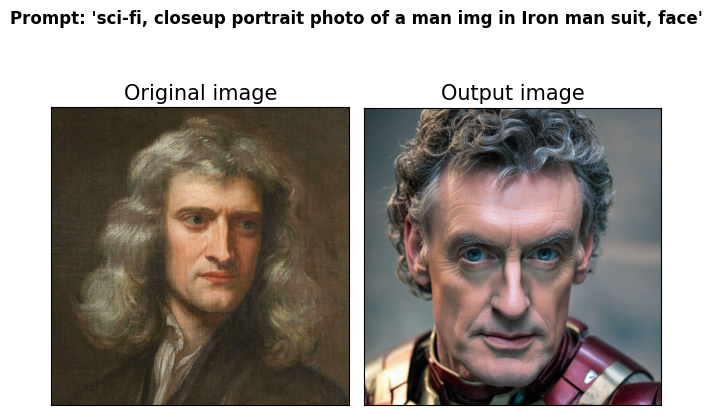

In [19]:
import matplotlib.pyplot as plt


def visualize_results(orig_img: Image.Image, output_img: Image.Image):
    """
    Helper function for pose estimationresults visualization

    Parameters:
       orig_img (Image.Image): original image
       output_img (Image.Image): processed image with PhotoMaker
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure
    """
    orig_img = orig_img.resize(output_img.size)
    orig_title = "Original image"
    output_title = "Output image"
    im_w, im_h = orig_img.size
    is_horizontal = im_h < im_w
    fig, axs = plt.subplots(
        2 if is_horizontal else 1,
        1 if is_horizontal else 2,
        sharex="all",
        sharey="all",
    )
    fig.suptitle(f"Prompt: '{prompt}'", fontweight="bold")
    fig.patch.set_facecolor("white")
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(output_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(output_title, fontsize=15)
    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00, hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    return fig


fig = visualize_results(original_image, images[0])

## Interactive Demo

[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


def generate_from_text(text_promt, input_image, neg_prompt, seed, num_steps, style_strength_ratio):
    """
    Helper function for generating result image from prompt text

    Parameters:
       text_promt (String): positive prompt
       input_image (Image.Image): original image
       neg_prompt (String): negative prompt
       seed (Int):  seed for random generator state initialization
       num_steps (Int): number of sampling steps
       style_strength_ratio (Int):  the percentage of step when merging the ID embedding to text embedding

    Returns:
       result (Image.Image): generation result
    """
    start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
    if start_merge_step > 30:
        start_merge_step = 30
    result = pipe(
        text_promt,
        input_id_images=input_image,
        negative_prompt=neg_prompt,
        num_inference_steps=num_steps,
        num_images_per_prompt=1,
        start_merge_step=start_merge_step,
        generator=torch.Generator().manual_seed(seed),
        height=1024,
        width=1024,
    ).images[0]

    return result


with gr.Blocks() as demo:
    with gr.Column():
        with gr.Row():
            input_image = gr.Image(label="Your image", sources=["upload"], type="pil")
            output_image = gr.Image(label="Generated Images", type="pil")
        positive_input = gr.Textbox(label=f"Text prompt, Trigger words is '{trigger_word}'")
        neg_input = gr.Textbox(label="Negative prompt")
        with gr.Row():
            seed_input = gr.Slider(0, 10_000_000, value=42, label="Seed")
            steps_input = gr.Slider(label="Steps", value=10, minimum=5, maximum=50, step=1)
            style_strength_ratio_input = gr.Slider(label="Style strength ratio", value=20, minimum=5, maximum=100, step=5)
            btn = gr.Button()
        btn.click(
            generate_from_text,
            [
                positive_input,
                input_image,
                neg_input,
                seed_input,
                steps_input,
                style_strength_ratio_input,
            ],
            output_image,
        )
        gr.Examples(
            [
                [prompt, negative_prompt],
                [
                    "A woman img wearing a Christmas hat",
                    negative_prompt,
                ],
                [
                    "A man img in a helmet and vest riding a motorcycle",
                    negative_prompt,
                ],
                [
                    "photo of a middle-aged man img sitting on a plush leather couch, and watching television show",
                    negative_prompt,
                ],
                [
                    "photo of a skilled doctor img in a pristine white lab coat enjoying a delicious meal in a sophisticated dining room",
                    negative_prompt,
                ],
                [
                    "photo of superman img flying through a vibrant sunset sky, with his cape billowing in the wind",
                    negative_prompt,
                ],
            ],
            [positive_input, neg_input],
        )


demo.queue().launch()
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
demo.close()